In [26]:
import pandas as pd

### Limits

In [27]:
# load data
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [35]:
# calculate yearly consumption
hp_yearly_consumption = 0
hh_yearly_consumption = 0
ev_yearly_consumption = 0
for idx_initial, household in household_config.iterrows():
    hh_yearly_consumption += df_hh[household["household_profile"]].sum() / 1000
    hp_yearly_consumption += df_hp[household["household_profile"]].sum() / 1000
    ev_load = df_ev[household["household_profile"]]
    ev_yearly_consumption += ev_load["Wh"].sum() / 1000
total_yearly_consumption = hh_yearly_consumption + hp_yearly_consumption + ev_yearly_consumption
print(f"Consumption HH: {round(hh_yearly_consumption, 2)}")
print(f"Consumption HP: {round(hp_yearly_consumption, 2)}")
print(f"Consumption EV: {round(ev_yearly_consumption, 2)}")
print(f"Total consumption: {round(total_yearly_consumption, 2)}")
print(f"Average consumption per hour and household: {round(total_yearly_consumption/len(household_config)/len(df_ev), 2)}")

Consumption HH: 1403835.74
Consumption HP: 2388752.13
Consumption EV: 968179.93
Total consumption: 4760767.8
Average consumption per hour and household: 1.09


In [36]:
# what if we only consider winter months
n_days = 90
hp_consumption = 0
hh_consumption = 0
ev_consumption = 0
for idx_initial, household in household_config.iterrows():
    hh_consumption += df_hh[household["household_profile"]][-n_days:].sum() / 1000
    hp_consumption += df_hp[household["household_profile"]][-n_days:].sum() / 1000
    ev_load = df_ev[household["household_profile"]]
    ev_consumption += ev_load["Wh"][-n_days:].sum() / 1000
total_consumption = hh_consumption + hp_consumption + ev_consumption
print(f"Consumption HH: {round(hh_consumption, 2)}")
print(f"Consumption HP: {round(hp_consumption, 2)}")
print(f"Consumption EV: {round(ev_consumption, 2)}")
print(f"Total consumption: {round(total_consumption, 2)}")
print(f"Average consumption per hour and household: {round(total_consumption / len(household_config) / n_days, 2)}")

Consumption HH: 15980.62
Consumption HP: 54566.78
Consumption EV: 6590.4
Total consumption: 77137.8
Average consumption per hour and household: 1.71


In [1], they use 2 kW and 4 kW as thresholds; this corresponds to E1max = 2 kWh and E2max = 2 kWh as we have an hourly resolution; based on above values, this also seems reasonable for our case.

[1] L. Bloch, J. Holweger, C. Ballif, and N. Wyrsch, “Impact of advanced electricity tariff structures on the optimal design, operation and profitability of a grid-connected PV system with energy storage,” Energy Inform., vol. 2, no. Suppl 1, p. 16, 2019, doi: 10.1186/s42162-019-0085-z.

### Grid charges

C:\Users\kkaiser\AppData\Local\anaconda3\envs\col_leo_anya\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Highest price:  0.21147
Lowest price:  0.0


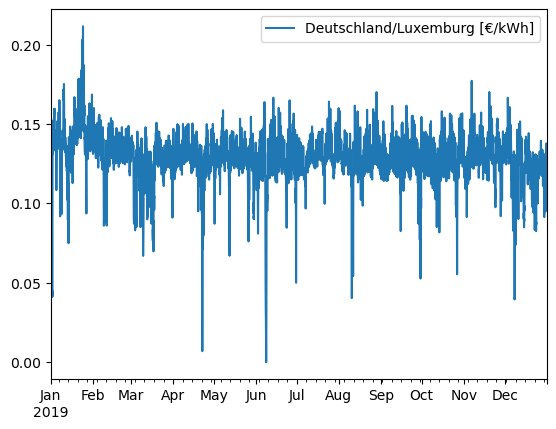

In [39]:
# How high are the energy prices?
df_price = pd.read_excel("./input/Gro_handelspreise_201901010000_201912312359_Stunde.xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df_ev.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.plot()
print("Highest price: ", df_p["Deutschland/Luxemburg [€/kWh]"].max())
print("Lowest price: ", df_p["Deutschland/Luxemburg [€/kWh]"].min())

The flat volumetric grid charge is 0.0722 €/kWh; --> scaling it by a factor of 2 seems reasonable.